In [3]:
import tensorflow as tf
import pandas as pd

# === Step 1: Load both CSVs ===
x_file = "X-Minutal.csv"
aw_file = "Full AWS.csv"

df_temp = pd.read_csv(x_file, sep=None, engine="python", on_bad_lines="skip")
df_aw = pd.read_csv(aw_file, sep=None, engine="python", on_bad_lines="skip")

# === Step 2: Clean column names ===
df_temp.columns = df_temp.columns.str.strip()
df_aw.columns = df_aw.columns.str.strip()

# === Step 3: Filter for device G97-N24 and date range (April 2024) ===
df_temp = df_temp[df_temp["﻿Device"] == "G97-N24"].copy()
df_temp["Date"] = pd.to_datetime(df_temp["Date"], format="%d/%m/%Y %H:%M:%S.%f")

mask_april = (df_temp["Date"] >= "2024-04-01") & (df_temp["Date"] <= "2024-04-30")
df_temp = df_temp.loc[mask_april]

# Extract Bearing D.E. temperature tensor
temp_tensor = tf.constant(df_temp["Bearing D.E. Temperature max 10M (ºC)"].values, dtype=tf.float32)
date_tensor = tf.constant(df_temp["Date"].astype("int64").values)

# === Step 4: Filter alarms & warnings for same device and date ===
df_aw = df_aw[df_aw["Device"] == "G97-N24"].copy()
df_aw["Timestamp"] = pd.to_datetime(df_aw["Timestamp"], format="%d/%m/%Y %H:%M:%S.%f", errors="coerce")
mask_aw = (df_aw["Timestamp"] >= "2024-04-01") & (df_aw["Timestamp"] <= "2024-04-30")
df_aw = df_aw.loc[mask_aw]

# Separate alarm and warning tensors
alarm_df = df_aw[df_aw["Category"].str.contains("Alarm", case=False, na=False)]
warning_df = df_aw[df_aw["Category"].str.contains("Warning", case=False, na=False)]

# === Step 5: Determine temp range thresholds ===
# Assuming alarm/warning timestamps match to closest recorded temperature samples
def temp_range_for_events(event_df, temp_df):
    if event_df.empty:
        return None, None
    merged = pd.merge_asof(
        event_df.sort_values("Timestamp"),
        temp_df.sort_values("Date"),
        left_on="Timestamp", right_on="Date", direction="nearest"
    )
    tmin, tmax = merged["Bearing D.E. Temperature max 10M (ºC)"].min(), merged["Bearing D.E. Temperature max 10M (ºC)"].max()
    return tmin, tma

tmin_alarm, tmax_alarm = temp_range_for_events(alarm_df, df_temp)
tmin_warn, tmax_warn = temp_range_for_events(warning_df, df_temp)

# === Step 6: Convert to TensorFlow tensors for final output ===
tmin_alarm_tf = tf.constant(tmin_alarm if tmin_alarm is not None else 0.0, dtype=tf.float32)
tmax_alarm_tf = tf.constant(tmax_alarm if tmax_alarm is not None else 0.0, dtype=tf.float32)
tmin_warn_tf = tf.constant(tmin_warn if tmin_warn is not None else 0.0, dtype=tf.float32)
tmax_warn_tf = tf.constant(tmax_warn if tmax_warn is not None else 0.0, dtype=tf.float32)

# === Step 7: Print threshold results ===
print("📊 Temperature Threshold Analysis (G97-N24, Apr 2024)")
print("---------------------------------------------------")
print(f"⚠️ Warning Range : {tmin_warn_tf.numpy():.2f}°C  →  {tmax_warn_tf.numpy():.2f}°C")
print(f"🚨 Alarm Range   : {tmin_alarm_tf.numpy():.2f}°C  →  {tmax_alarm_tf.numpy():.2f}°C")

# === Step 8 (Optional): Plot the trend with TensorFlow data ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_temp["Date"], temp_tensor.numpy(), color="tab:red", label="Bearing D.E. Temp (°C)")
if tmin_alarm and tmax_alarm:
    plt.axhline(y=tmin_alarm, color='orange', linestyle='--', label='Alarm Min Threshold')
    plt.axhline(y=tmax_alarm, color='red', linestyle='--', label='Alarm Max Threshold')
if tmin_warn and tmax_warn:
    plt.axhline(y=tmin_warn, color='green', linestyle='--', label='Warning Min Threshold')
    plt.axhline(y=tmax_warn, color='lime', linestyle='--', label='Warning Max Threshold')

plt.title("Device G97-N24 | Apr 2024 | Bearing D.E. Temperature vs Alarms/Warnings")
plt.xlabel("Date (April 2024)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


KeyError: 'Timestamp'

In [4]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# === Step 1: Load both CSV files ===
df_temp = pd.read_csv("X-Minutal.csv")       # Temperature data
df_alarm = pd.read_csv("Full AWS.csv")   # Alarm/Warning data

# === Step 2: Filter only for the desired device ===
device_id = "G97-N24"
df_temp = df_temp[df_temp["Device"] == device_id].copy()
df_alarm = df_alarm[df_alarm["Device"] == device_id].copy()

# === Step 3: Convert date columns to datetime ===
df_temp["Date"] = pd.to_datetime(df_temp["Date"], format="%d/%m/%Y", errors="coerce")
df_alarm["Date"] = pd.to_datetime(df_alarm["Date"], format="%d/%m/%Y", errors="coerce")

# === Step 4: Select only April 2024 data ===
mask = (df_temp["Date"] >= "2024-04-01") & (df_temp["Date"] <= "2024-04-30")
df_temp = df_temp.loc[mask]

mask_alarm = (df_alarm["Date"] >= "2024-04-01") & (df_alarm["Date"] <= "2024-04-30")
df_alarm = df_alarm.loc[mask_alarm]

# === Step 5: Extract relevant parameter column ===
col_name = "Bearing D.E. Temperature Max 10M"  # match exact column name
df_temp = df_temp[["Date", col_name]].dropna()

# === Step 6: Analyze thresholds for Alarm and Warning ===
alarm_values = df_alarm[df_alarm["Category"].str.contains("Alarm", case=False, na=False)]
warning_values = df_alarm[df_alarm["Category"].str.contains("Warning", case=False, na=False)]

# If temperature column exists in alarm data too
if col_name in df_alarm.columns:
    alarm_min = alarm_values[col_name].min()
    alarm_max = alarm_values[col_name].max()
    warning_min = warning_values[col_name].min()
    warning_max = warning_values[col_name].max()
else:
    alarm_min = alarm_max = warning_min = warning_max = None

print("\n=== Temperature Threshold Summary (°C) ===")
print(f"Alarm Raised Between: {alarm_min} – {alarm_max}")
print(f"Warning Raised Between: {warning_min} – {warning_max}")

# === Step 7: Convert temperature data to TensorFlow tensor ===
temp_tensor = tf.constant(df_temp[col_name].values, dtype=tf.float32)

# === Step 8: Plot temperature line graph ===
plt.figure(figsize=(12, 6))
plt.plot(df_temp["Date"], df_temp[col_name], color="teal", label="Bearing D.E. Temp (Max 10M)")
plt.title(f"Device {device_id} — April 2024 Temperature Trend", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ParserError: Error tokenizing data. C error: Expected 1 fields in line 742, saw 2


In [5]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# === Step 1: Load both CSVs safely ===
def safe_read_csv(path):
    return pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip")

df_temp = safe_read_csv("X-Minutal.csv")      # Temperature data
df_alarm = safe_read_csv("Full AWS.csv")      # Alarm/Warning data

print("Temperature CSV Columns:\n", df_temp.columns, "\n")
print("Alarm/Warning CSV Columns:\n", df_alarm.columns, "\n")

# === Step 2: Filter only for device G97-N24 ===
device_id = "G97-N24"
df_temp = df_temp[df_temp["Device"] == device_id].copy()
df_alarm = df_alarm[df_alarm["Device"] == device_id].copy()

# === Step 3: Convert date columns ===
# (If your date column has different name, update below)
df_temp["Date"] = pd.to_datetime(df_temp["Date"], errors="coerce", dayfirst=True)
df_alarm["Date"] = pd.to_datetime(df_alarm["Date"], errors="coerce", dayfirst=True)

# === Step 4: Filter April 2024 data ===
mask_temp = (df_temp["Date"] >= "2024-04-01") & (df_temp["Date"] <= "2024-04-30")
mask_alarm = (df_alarm["Date"] >= "2024-04-01") & (df_alarm["Date"] <= "2024-04-30")
df_temp = df_temp.loc[mask_temp]
df_alarm = df_alarm.loc[mask_alarm]

# === Step 5: Extract parameter column ===
col_name = "Bearing D.E. Temperature Max 10M"  # adjust if name slightly differs
df_temp = df_temp[["Date", col_name]].dropna()

# === Step 6: Threshold analysis ===
alarm_rows = df_alarm[df_alarm["Category"].str.contains("Alarm", case=False, na=False)]
warning_rows = df_alarm[df_alarm["Category"].str.contains("Warning", case=False, na=False)]

if col_name in df_alarm.columns:
    alarm_min = alarm_rows[col_name].min()
    alarm_max = alarm_rows[col_name].max()
    warning_min = warning_rows[col_name].min()
    warning_max = warning_rows[col_name].max()
else:
    alarm_min = alarm_max = warning_min = warning_max = None

print("\n=== Temperature Threshold Summary (°C) ===")
print(f"Alarm Range: {alarm_min} – {alarm_max}")
print(f"Warning Range: {warning_min} – {warning_max}")

# === Step 7: Convert temp data to TensorFlow tensor ===
temp_tensor = tf.constant(df_temp[col_name].values, dtype=tf.float32)

# === Step 8: Plot ===
plt.figure(figsize=(12, 6))
plt.plot(df_temp["Date"], df_temp[col_name], color="orange", linewidth=2, label="Bearing D.E. Temp Max 10M")
plt.title(f"{device_id} — Temperature Trend (Apr 2024)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Temperature CSV Columns:
 Index(['﻿Device', 'Date', 'Trafo 2 winding temperature max 10M (ºC)',
       'Trafo 3 winding temperature max 10M (ºC)',
       'Average Active Power 10M (kW)', 'Average Wind Speed 10M (m/s)',
       'Bearing D.E. Temperature max 10M (ºC)',
       'Bearing N.D.E. Temperature max 10M (ºC)',
       'Gearbox bearing temperature max 10M (ºC)',
       'Gearbox oil temperature max 10M (ºC)',
       'Generator windings temperature 1 max 10M (ºC)',
       'Generator windings temperature 2 max 10M (ºC)',
       'Generator windings temperature 3 max 10M (ºC)',
       'Generator’s sliprings temperature max 10M (ºC)',
       'Max. Ambient Temperature 10M (ºC)',
       'Nacelle temperature average 10M (ºC)',
       'Trafo 1 winding temperature max 10M (ºC)'],
      dtype='object') 

Alarm/Warning CSV Columns:
 Index(['﻿Power Plant', 'Device', 'Category', 'Event',
       'Subevent / Categorization', 'Start Date', 'End Date', 'Duration',
       'Categorization description'],

KeyError: 'Device'


=== Bearing D.E. Temperature Thresholds for April 2024 ===
Alarm range (°C): 56.4 – 58.3
Warning range (°C): 53.9 – 62.4


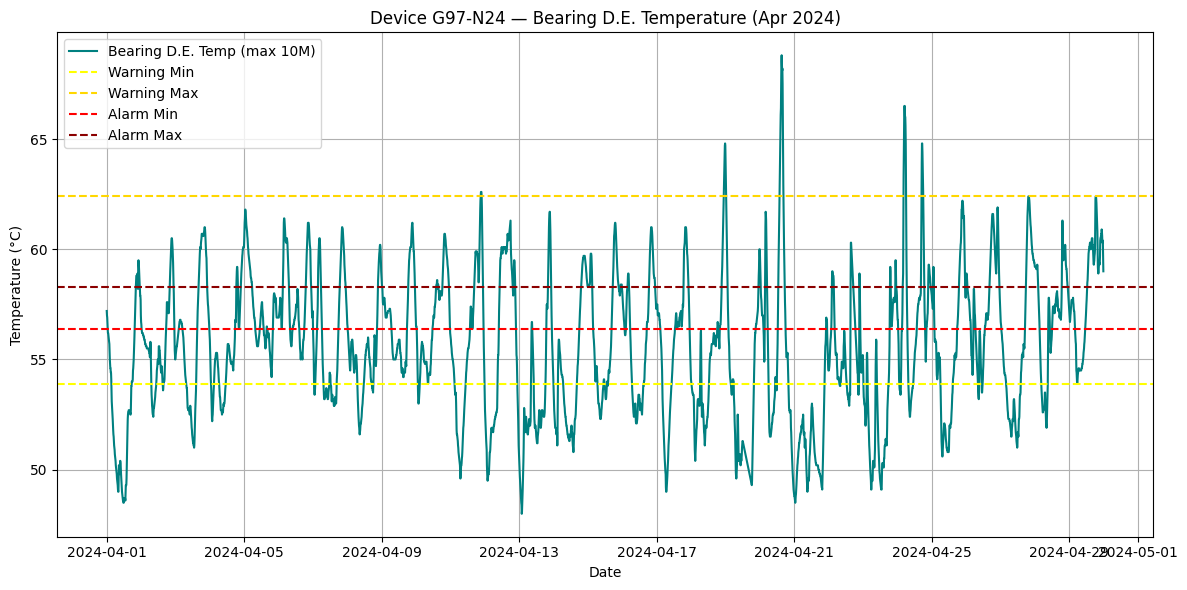

In [6]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


def safe_read_csv(path):
    return pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip")

df_temp = safe_read_csv("X-Minutal.csv")   
df_alarm = safe_read_csv("Full AWS.csv")   


df_temp.columns = df_temp.columns.str.strip()
df_alarm.columns = df_alarm.columns.str.strip()


device_id = "G97-N24"
df_temp = df_temp[df_temp["﻿Device"] == device_id].copy()
df_alarm = df_alarm[df_alarm["Device"] == device_id].copy()


df_temp["Date"] = pd.to_datetime(df_temp["Date"], errors="coerce", dayfirst=True)
df_alarm["Start Date"] = pd.to_datetime(df_alarm["Start Date"], errors="coerce", dayfirst=True)
df_alarm["End Date"] = pd.to_datetime(df_alarm["End Date"], errors="coerce", dayfirst=True)


mask_temp = (df_temp["Date"] >= "2024-04-01") & (df_temp["Date"] <= "2024-04-30")
mask_alarm = (df_alarm["Start Date"] >= "2024-04-01") & (df_alarm["Start Date"] <= "2024-04-30")
df_temp = df_temp.loc[mask_temp]
df_alarm = df_alarm.loc[mask_alarm]


col_name = "Bearing D.E. Temperature max 10M (ºC)"
df_temp = df_temp[["Date", col_name]].dropna()


alarms = df_alarm[df_alarm["Category"].str.contains("Alarm", case=False, na=False)]
warnings = df_alarm[df_alarm["Category"].str.contains("Warning", case=False, na=False)]


alarm_periods = []
warning_periods = []

for _, row in alarms.iterrows():
    mask = (df_temp["Date"] >= row["Start Date"]) & (df_temp["Date"] <= row["End Date"])
    alarm_periods.append(df_temp.loc[mask, col_name].values)

for _, row in warnings.iterrows():
    mask = (df_temp["Date"] >= row["Start Date"]) & (df_temp["Date"] <= row["End Date"])
    warning_periods.append(df_temp.loc[mask, col_name].values)

import numpy as np
alarm_values = np.concatenate(alarm_periods) if alarm_periods else np.array([])
warning_values = np.concatenate(warning_periods) if warning_periods else np.array([])

alarm_min = alarm_values.min() if alarm_values.size > 0 else None
alarm_max = alarm_values.max() if alarm_values.size > 0 else None
warn_min = warning_values.min() if warning_values.size > 0 else None
warn_max = warning_values.max() if warning_values.size > 0 else None

print("\n=== Bearing D.E. Temperature Thresholds for April 2024 ===")
print(f"Alarm range (°C): {alarm_min} – {alarm_max}")
print(f"Warning range (°C): {warn_min} – {warn_max}")


temp_tensor = tf.constant(df_temp[col_name].values, dtype=tf.float32)


plt.figure(figsize=(12, 6))
plt.plot(df_temp["Date"], df_temp[col_name], label="Bearing D.E. Temp (max 10M)", color="teal")
if warn_min is not None:
    plt.axhline(warn_min, color="yellow", linestyle="--", label="Warning Min")
    plt.axhline(warn_max, color="gold", linestyle="--", label="Warning Max")
if alarm_min is not None:
    plt.axhline(alarm_min, color="red", linestyle="--", label="Alarm Min")
    plt.axhline(alarm_max, color="darkred", linestyle="--", label="Alarm Max")

plt.title(f"Device {device_id} — Bearing D.E. Temperature (Apr 2024)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
print("\n=== Summary of April 2024 Temperature Ranges ===")
print(f"Device: {device_id}")
print(f"Parameter: {col_name}")
print(f"Warning Range : {warn_min:.2f} °C – {warn_max:.2f} °C")
print(f"Alarm Range   : {alarm_min:.2f} °C – {alarm_max:.2f} °C")



=== Summary of April 2024 Temperature Ranges ===
Device: G97-N24
Parameter: Bearing D.E. Temperature max 10M (ºC)
Warning Range : 53.90 °C – 62.40 °C
Alarm Range   : 56.40 °C – 58.30 °C
